ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **10Apr21**

# 06d. Poisson 3D with Dirichlet Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\flux}{\boldsymbol{q}}
  \newcommand{\normal}{\boldsymbol{n}}
  \newcommand{\xpoint}{\boldsymbol{x}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\div}{div}
  \DeclareMathOperator{\grad}{grad}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br>
1. [Problem Statement](#problem)
 + [Strong Form](#dbcstrong)
 + [Variational Form](#dbcweak)
 + [Dirichlet Energy](#energy)
<br><br>
1. [Problem Solution](#solution)
 + [MOOSE Application Development](#dbcapp)
<br><br>   
1. [Linear Lagrange FEM Results](#dbclinearfemresults)
<br><br>    
1. [Quadratic Lagrange FEM Results](#dbcquadfemresults)
<br><br>   
1. [Energy Postprocessing](#energypostpro)
<br><br>   
1. [Application Tree](#tree)
---

## [Objectives](#toc)<a id="obj"></a>

 + Extend the Poisson 2D problem covered in [Notebook 06b](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06b-poisson-2d-dirichlet.ipynb) to a generic 3D case. Notes for the 1D and 2D problems must be thoroughly reviewed.
 + Introduce the Galerkin variational (weak) form of the Poisson 2D problem below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
 + <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. A significant effort in programing is often necessary to learn the subject well. However the material in this course is helpful with this task. Hands-on work during lectures will try to fill in existing gap. The steps in this notebook are necessary for a basic understanding of the subject.</span>
 + You are supposed to consult the [`MOOSE source documentation`](https://mooseframework.inl.gov/source/index.html) to fill in gaps in reproducing the steps below.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['z'], df['u'],'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$z$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(z)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_z' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['z'], df['diffFluxU_z'],'*-', color='yellow', label='$q_{n,z}$ flux_basis_functions_type')
        ax2.set_ylabel(r"$q_n$ [g/cm$^2$-s]", fontsize=16, color='yellow')
                 
        if 'diffFluxU_x' in df.columns:
            ax2.plot(df['z'], df['diffFluxU_x'],'-', color='yellow', label='$q_{n,x}$ flux_basis_functions_type')
        if 'diffFluxU_y' in df.columns:
            ax2.plot(df['z'], df['diffFluxU_y'],'-', color='orange', label='$q_{n,y}$ flux_basis_functions_type')
                     
        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)
        
    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## [Problem Statement](#toc)<a id="problem"></a>

The following sections describe what is referred in the literature as the two-dimensional Poisson problem with Dirichlet boundary condition.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Poisson model problem. Find $u:\Omega\subset\Reals^2\rightarrow\Reals$ such that:

\begin{align*}
 -\div_\xpoint(-D\, \grad_\xpoint u) + S &= 0 \quad &\forall \quad \xpoint\in \Omega, \\
 u(\xpoint) &= u_\text{b}(\xpoint)            \quad &\forall \quad \xpoint\in \partial\Omega
\end{align*}
   
This problem has an analytical solution for certain domains $\Omega$ however this solution is not required here. The *flux*, $\flux:\Omega\rightarrow\Reals^2$, associated to the quantity $u$, is denoted $\flux := -D\,\grad u$, and it is often of interest as a derived quantity.

The value of the dependent variable is given on the boundary of the domain $\partial\Omega$. This is the extension of the *essential* boundary condition or  *Dirichlet boundary condition* to 2D.

### [Variational Form of Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin variational formulation is as follows. Find $u \in H^1\!\bigl(\Omega\bigr)$ so that 

\begin{align*}
 \int\limits_\Omega -D\, \grad_\xpoint u \cdot \grad_\xpoint v\,d\xpoint + \int\limits_\Omega S\,v(\xpoint)\,d\xpoint &= 0 \quad \forall \quad v \in H^1_0\!\bigl(\Omega\bigr), 
\end{align*}

where $H^1\!\bigl(\Omega\bigr) := \bigl\{ u:\Omega\subset\Reals\rightarrow \Reals \mid \int_\Omega \grad_\xpoint u\cdot\grad_\xpoint u\,d\xpoint < \infty \bigr\}$ and 
$H^1_0\!\bigl(\Omega\bigr) := \bigl\{ v \mid v \in H^1(\Omega), v|_{\partial\Omega} = 0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $v$ is called a test function. Because $v$ and $u$ are sought in very similar sets of functions, this variational form is called Galerkin's variational form.

The two integrals in the variational formulation are the key terms to be computed. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integrals, that is, the kernels. Therefore the kernels needed are:

 1. $-D\, \grad_\xpoint u \cdot \grad_\xpoint v$ ,
 1. $S\,v(\xpoint)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.

### [Poisson-Dirichlet Energy](#toc)<a id="energy"></a>

It is of theoretical and practical importance to compute the associated energy that the variational form minimizes, that is the **Poisson-Dirichlet total energy**:

\begin{align*}
 \Phi[u] := \int\limits_\Omega \,\frac{1}{2}\flux(\xpoint)\cdot\flux(\xpoint) - D\,S\,u(\xpoint) \,d\xpoint.
\end{align*}

Since this is done after the solution is computed, it is characterized as a *postprocessing* operation. In `MOOSE` this is implemented in a *Postprocessors* class. First however, any derived quantity used in the integrand needs to be passed to the preprocessor for integration. Here we need to compute the local *flux*, $q$. In `MOOSE` this is done by creating an *auxiliary* variable and a corresponding *auxiliary kernel*. Therefore there are two additional components to [setup](#energypostpro):

1. Create the auxiliary variable $\flux=-D\,\grad u$,
1. Create the posprocessor for computing $\Phi$.

## [Problem Solution](#toc)<a id="solution"></a>

There is very little to do in order to extend the work done in 1D ([Notebook 06](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06-poisson-1d-dirichlet.ipynb)) if the programming was done with an eye towards 2D and 3D. The major work to be done is in the `MOOSE` input file.

### [MOOSE Application Development](#toc)<a id="dbcapp"></a>

We will use the same application development as in [Notebook 06](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06-poisson-1d-dirichlet.ipynb), namely `engy5310p1`.

## [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + See domain below
> + u_bottom= 3 g/cc
> + u_top = 0 g/cc
> + u_west = 0 g/cc
> + u_east = 2 g/cc
> + u_south = 0 g/cc
> + u_north = 1 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: First Order Lagrange
> + num. of finite elements in the *x* direction: 20
> + num. of finite element in the *y* direction: 10

In [2]:
'''Domain'''

z_bottom = 0.0
z_top = 25
z_length = z_top - z_bottom

x_length = z_length/2
x_west = -x_length/2
x_east = -x_west

y_length = x_length
y_south = -x_length/2.0
y_north = -y_south

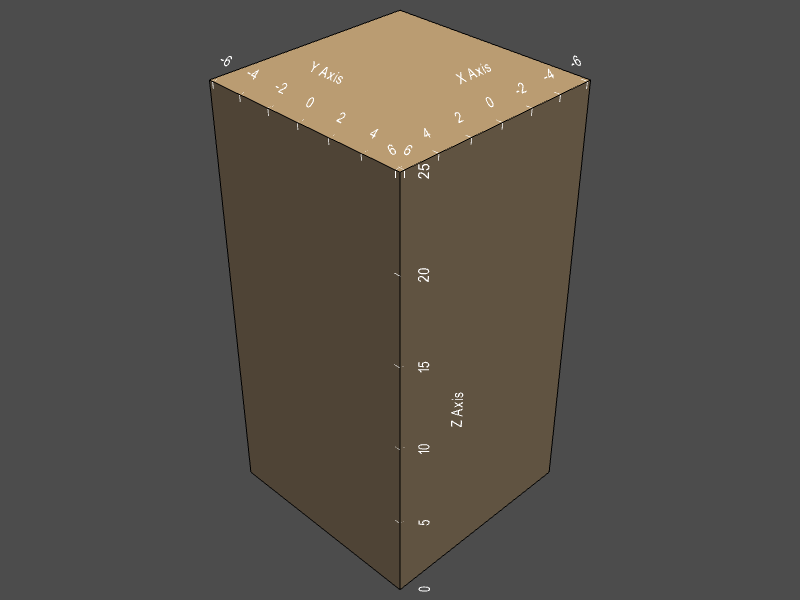

In [3]:
import pyvista as pv
import numpy as np
p1 = np.array([x_west, y_south, z_bottom])
p2 = np.array([x_east, y_south, z_bottom])
p3 = np.array([x_east, y_north, z_bottom])
p4 = np.array([x_west, y_north, z_bottom])

p5 = np.array([x_west, y_south, z_top])
p6 = np.array([x_east, y_south, z_top])
p7 = np.array([x_east, y_north, z_top])
p8 = np.array([x_west, y_north, z_top])
center = (p1+p2+p3+p4+p5+p6+p7+p8)/8
cube = pv.Cube(center=center, x_length=x_length, y_length=y_length, z_length=z_length)
#cube = pv.Cube(center=(0,0,0), x_length=x_length, y_length=7, z_length=5)

plt = pv.Plotter()
plt.add_mesh(cube, color='tan', show_edges=True)
plt.show_bounds()
cpos = plt.show(window_size=[800,600])

In [4]:
'''Parameters and data'''

diff_coeff = 0.1
source_s = 1e-3

u_bottom = 3
u_top = 0

u_west = 0
u_east = 2

u_south = 0
u_north = 1

In [5]:
'''FEM Solution'''

n_felem_x = 10
n_felem_y = 10
n_felem_z = 20

order = 'first'

n_plot_pts_x = n_felem_x + 1
n_plot_pts_y = n_felem_y + 1
n_plot_pts_z = n_felem_z + 1

from engy_5310.toolkit import write_engy5310_p1_3d_input_file

write_engy5310_p1_3d_input_file(x_west=x_west, x_east=x_east, y_south=y_south, y_north=y_north, z_bottom=z_bottom, z_top=z_top, 
                                u_west=u_west, u_east=u_east, u_south=u_south, u_north=u_north, u_bottom=u_bottom, u_top=u_top, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, n_felem_z=n_felem_z,                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y, n_plot_pts_z=n_plot_pts_z,
                                compute_diffusion_flux=True)

In [6]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 3D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 12:53:50

# Parameters
xmin = -6.25000e+00
xmax = 6.25000e+00
ymin = -6.25000e+00
ymax = 6.25000e+00
zmin = 0.00000e+00
zmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_west = 0.00000e+00
u_east = 2.00000e+00
u_south = 0.00000e+00
u_north = 1.00000e+00
u_bottom = 3.00000e+00
u_top = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [3d]
    type = GeneratedMeshGenerator
    dim = 3
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    zmin = ${replace zmin}
    zmax = ${replace zmax}
    nx = 10
    ny = 10
    nz = 20
  []
[]

[Variables]
  [u]
    order = first
    family = lagrange
    initial_condition = ${fparse (u_west+u_east+u_south+u_north+u_bottom+u_top)/6}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = CONSTANT
    family = MONOMIAL_VEC
  []
  [diffFluxU_x

In [7]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 12:54:35 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          3
  Spatial Dimension:       3
  Nodes:                   
    Total:                 2541
    Local:                 2541
  Elems:                   
    Total:                 2000
    Local:                 2000
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                2541
  Num Local DOFs:          2541
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary System:
  Num DOFs:                12000
  Num Local DOFs:       

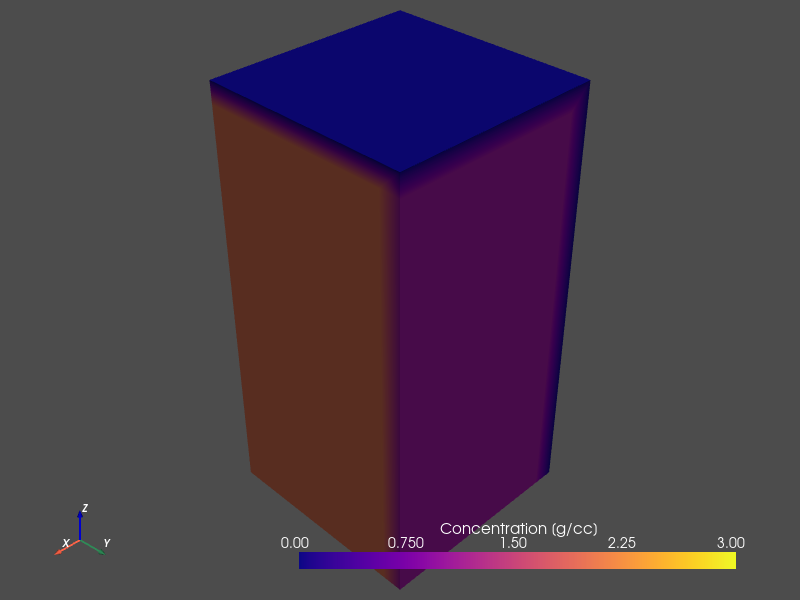

In [8]:
'''Show 3D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='u', stitle='Concentration [g/cc]', cmap='plasma', window_size=[800,600], notebook=True)

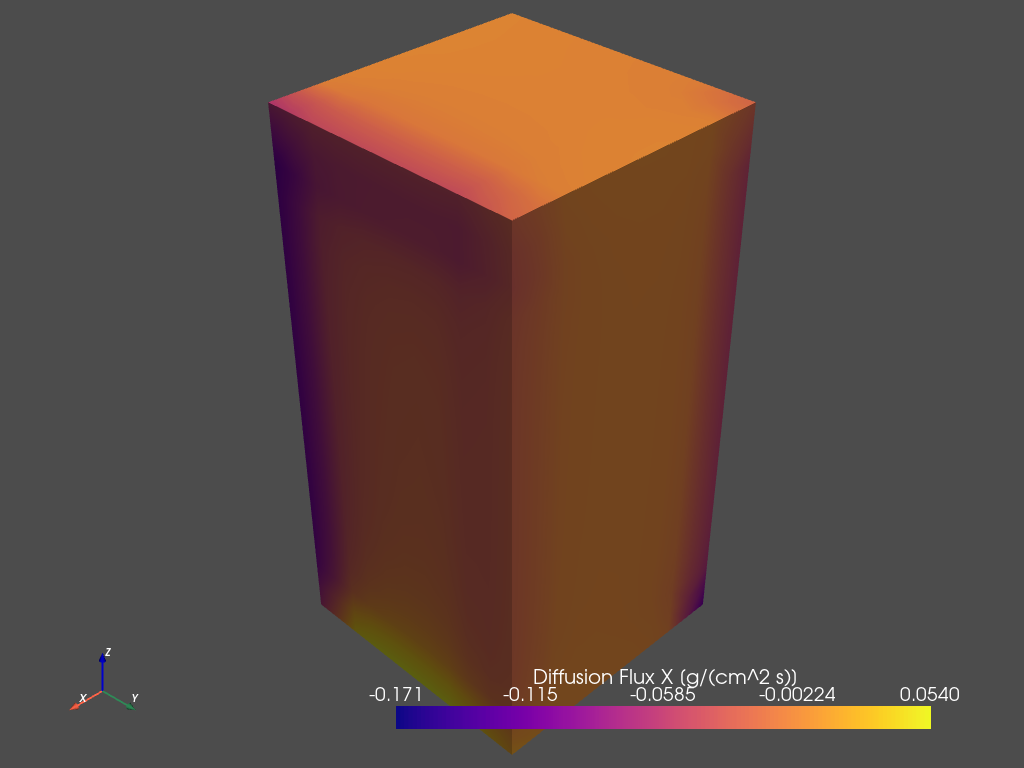

In [9]:
'''Show 3D x flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_x', stitle='Diffusion Flux X [g/(cm^2 s)]', cmap='plasma', notebook=True) 

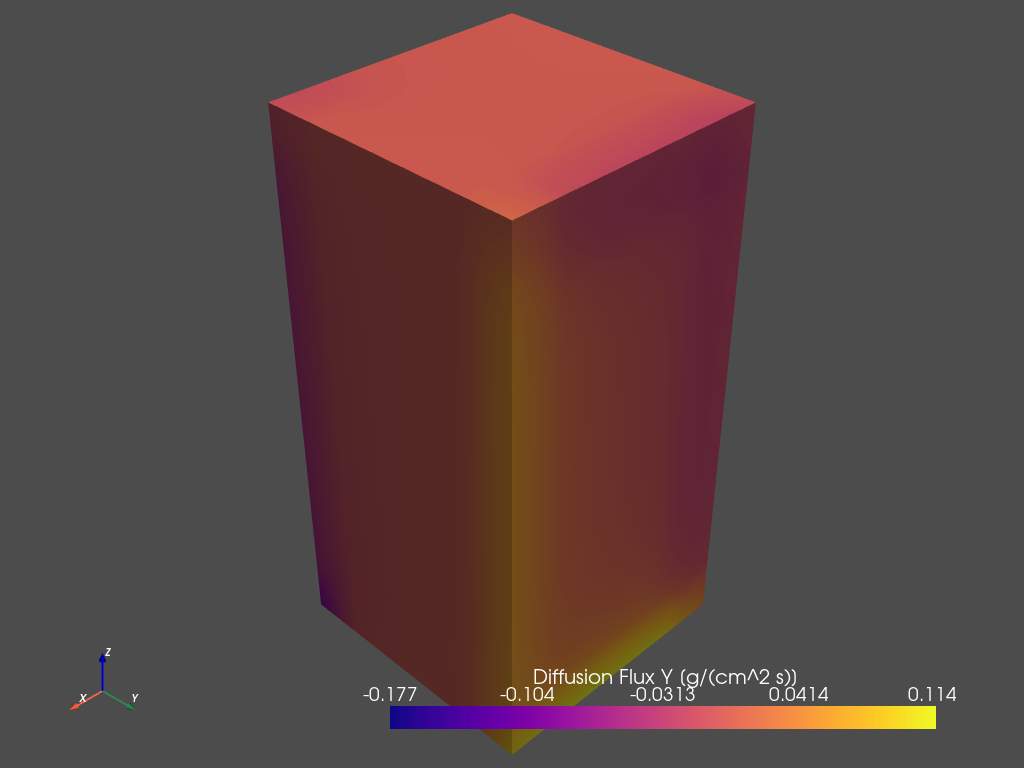

In [10]:
'''Show 3D y flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_y', stitle='Diffusion Flux Y [g/(cm^2 s)]', cmap='plasma', notebook=True)

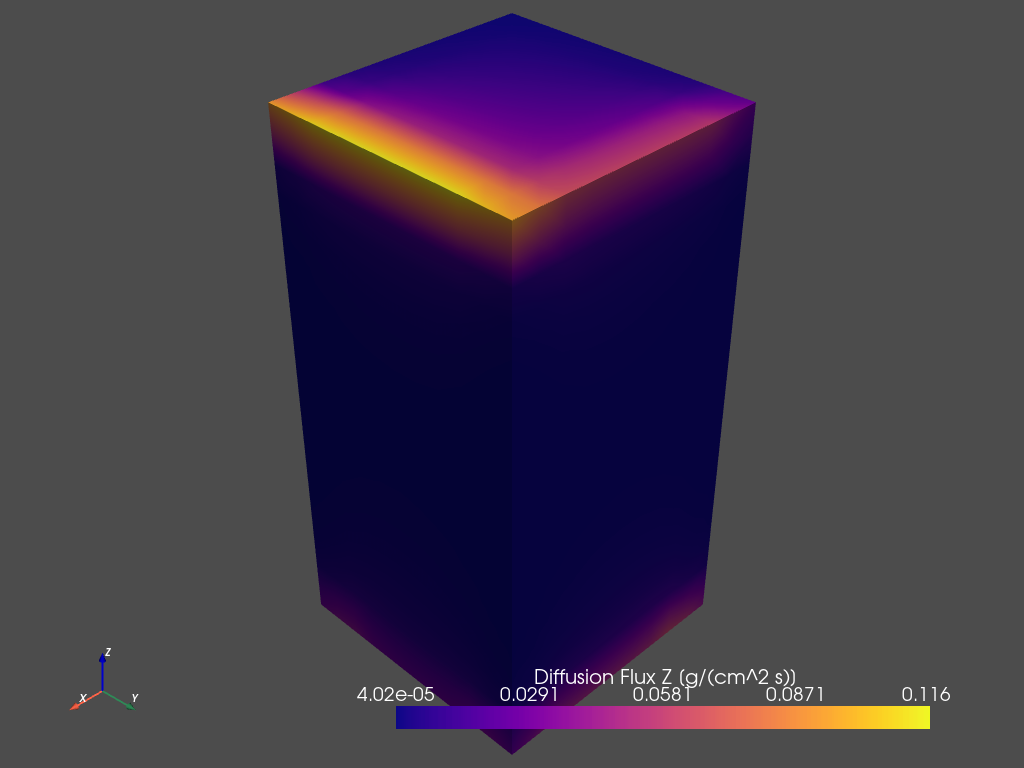

In [11]:
'''Show 3D z flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_z', stitle='Diffusion Flux Z [g/(cm^2 s)]', cmap='plasma', notebook=True)

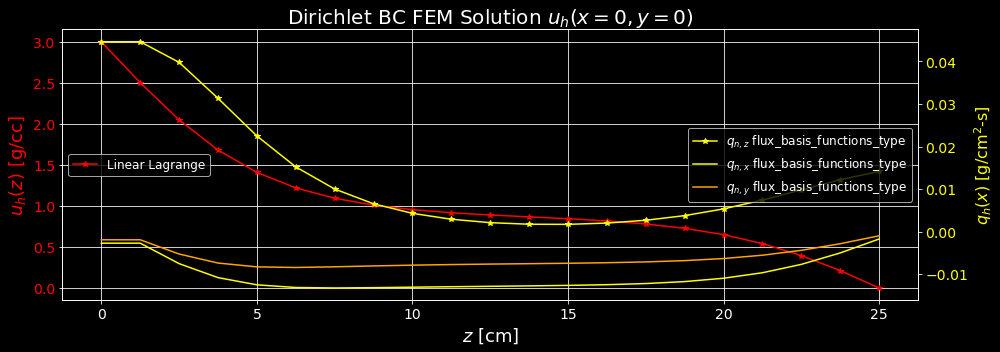

In [12]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('out-z_z-line_0002.csv')
    
plot_solution(df, title='Dirichlet BC FEM Solution $u_h(x=0,y=0)$', basis_functions_type='Linear Lagrange', flux_basis_functions_type='Constant Monomial')

**Comments:**

1. The *concentration* drops from the entry value to the exit as prescribed by the boundary conditions.
1. Because of the non-zero source term the profile is quadratic.
1. The normal diffusion flux is negative on the left boundary, $(\flux\cdot\normal)|_{\xpoint = (a,y)} < 0$, 
hence there is *feeding* on the left. On the right boundary $(\flux\cdot\normal)|_{\xpoint = (a,y)} > 0$ therefore there is *draining* at the right side.

## [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

FEM parameters:

> + Basis Functions: Second Order Lagrange
> + num. of finite elements in the *x* direction: 20
> + num. of finite element in the *y* direction: 10

In [13]:
'''FEM Solution'''

n_felem_x = 10
n_felem_y = 10
n_felem_z = 20

order = 'second'

n_plot_pts_x = n_felem_x + 1
n_plot_pts_y = n_felem_y + 1
n_plot_pts_z = n_felem_z + 1

from engy_5310.toolkit import write_engy5310_p1_3d_input_file

write_engy5310_p1_3d_input_file(x_west=x_west, x_east=x_east, y_south=y_south, y_north=y_north, z_bottom=z_bottom, z_top=z_top, 
                                u_west=u_west, u_east=u_east, u_south=u_south, u_north=u_north, u_bottom=u_bottom, u_top=u_top, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, n_felem_z=n_felem_z,                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y, n_plot_pts_z=n_plot_pts_z,
                                compute_diffusion_flux=True)

In [14]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 3D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 12:54:51

# Parameters
xmin = -6.25000e+00
xmax = 6.25000e+00
ymin = -6.25000e+00
ymax = 6.25000e+00
zmin = 0.00000e+00
zmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_west = 0.00000e+00
u_east = 2.00000e+00
u_south = 0.00000e+00
u_north = 1.00000e+00
u_bottom = 3.00000e+00
u_top = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [3d]
    type = GeneratedMeshGenerator
    dim = 3
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    zmin = ${replace zmin}
    zmax = ${replace zmax}
    nx = 10
    ny = 10
    nz = 20
    elem_type = HEX27
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_west+u_east+u_south+u_north+u_bottom+u_top)/6}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC

In [15]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 12:54:53 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          3
  Spatial Dimension:       3
  Nodes:                   
    Total:                 18081
    Local:                 18081
  Elems:                   
    Total:                 2000
    Local:                 2000
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                18081
  Num Local DOFs:          18081
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                48000
  Num Local DOFs:  

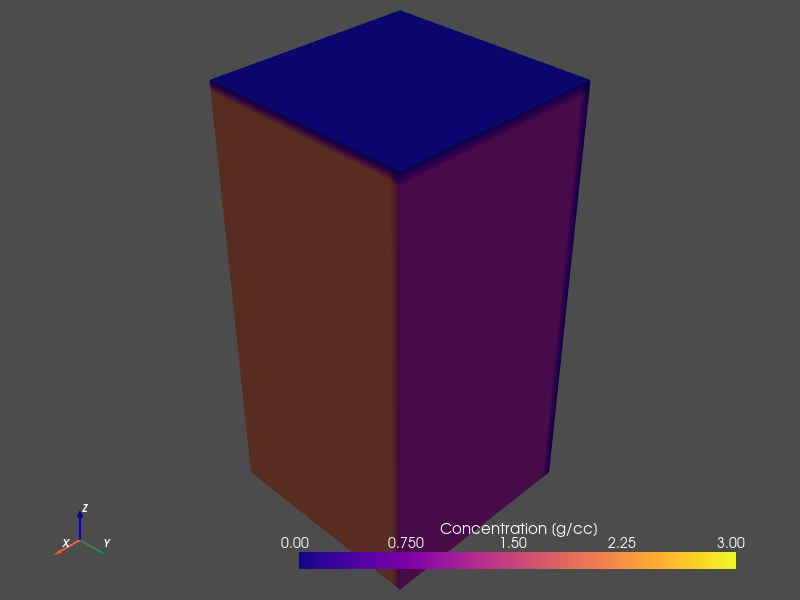

In [16]:
'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='u', stitle='Concentration [g/cc]', cmap='plasma', window_size=[800,600], notebook=True)

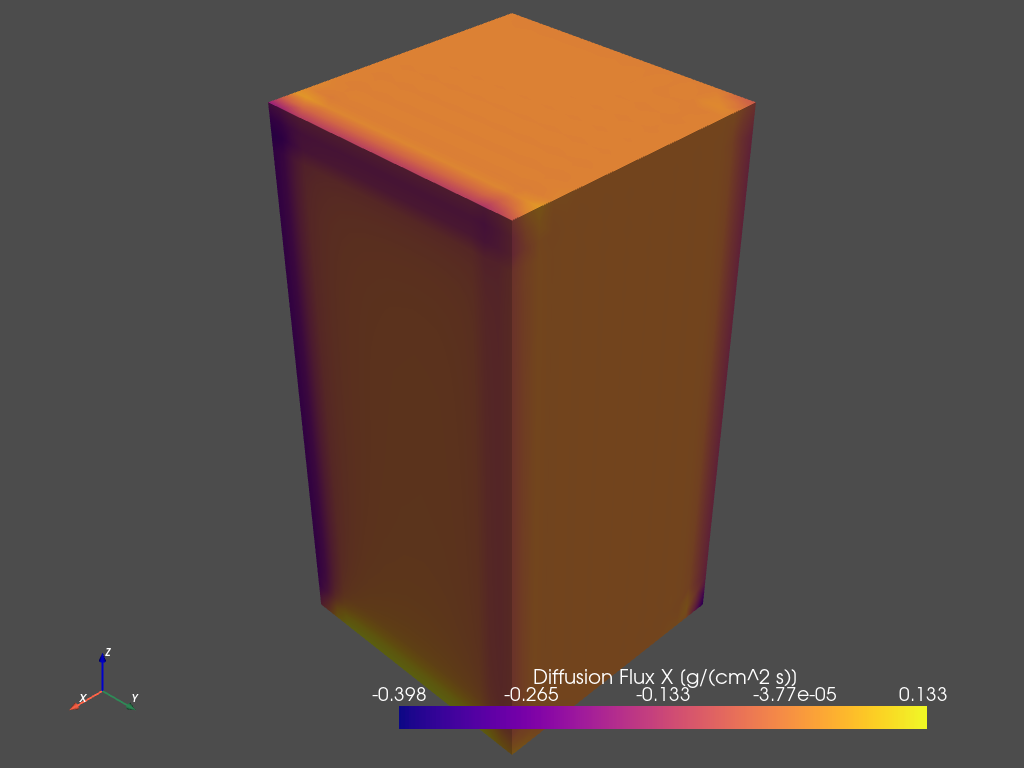

In [17]:
'''Show 3D x flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_x', stitle='Diffusion Flux X [g/(cm^2 s)]', cmap='plasma', notebook=True) 

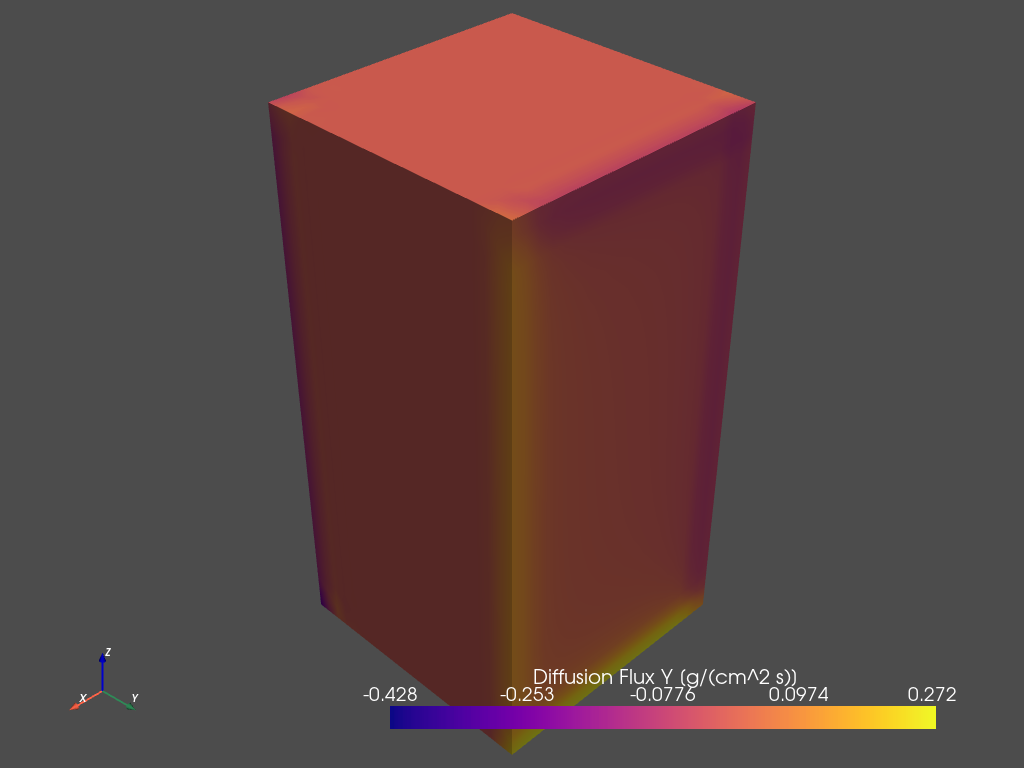

In [18]:
'''Show 3D y flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_y', stitle='Diffusion Flux Y [g/(cm^2 s)]', cmap='plasma', notebook=True)

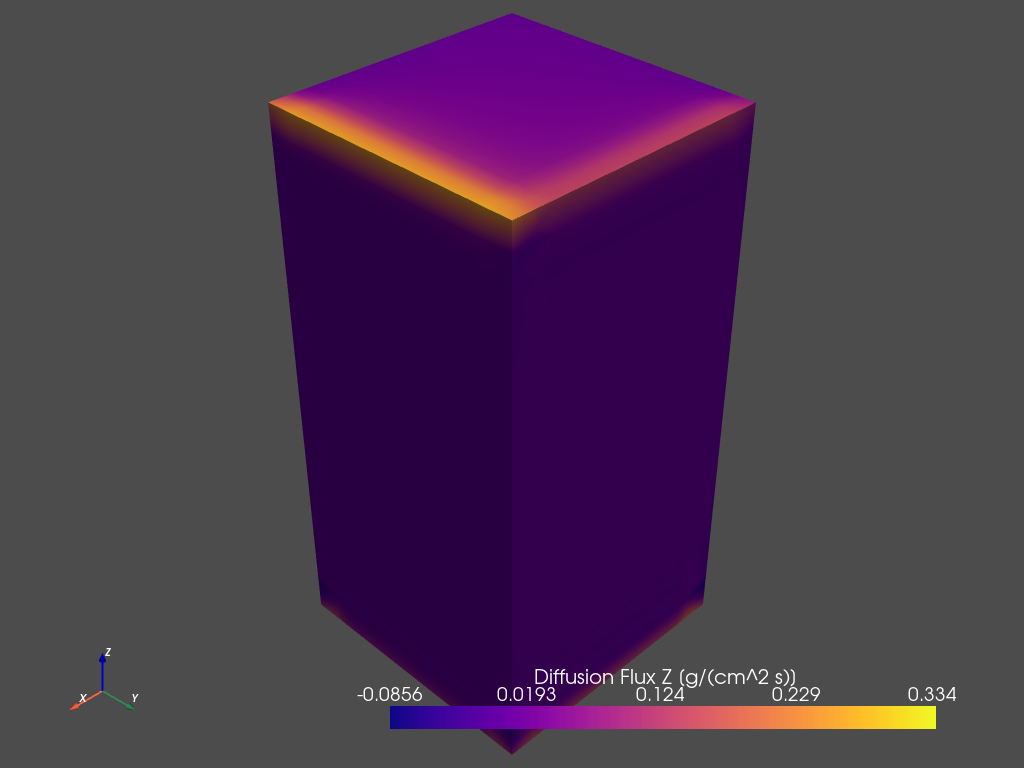

In [19]:
'''Show 3D z flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_z', stitle='Diffusion Flux Z [g/(cm^2 s)]', cmap='plasma', notebook=True)

## [Energy Postprocessing](#toc)<a id="energypostpro"></a>

To compute the [Dirichlet energy](#energy) a *Postprocessor* needs to be built. The user-developed class should use the previously computed diffusion flux component. With an eye towards the future use of this application in 2D and 3D, call this new class, `BulkEnergy`.

In [24]:
n_felem_x = 10
n_felem_y = 10
n_felem_z = 20

order = 'second'

n_plot_pts_x = n_felem_x + 1
n_plot_pts_y = n_felem_y + 1
n_plot_pts_z = n_felem_z + 1

from engy_5310.toolkit import write_engy5310_p1_3d_input_file

write_engy5310_p1_3d_input_file(x_west=x_west, x_east=x_east, y_south=y_south, y_north=y_north, z_bottom=z_bottom, z_top=z_top, 
                                u_west=u_west, u_east=u_east, u_south=u_south, u_north=u_north, u_bottom=u_bottom, u_top=u_top, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, n_felem_z=n_felem_z,                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y, n_plot_pts_z=n_plot_pts_z,
                                compute_energy=True)

In [25]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 3D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 12:56:23

# Parameters
xmin = -6.25000e+00
xmax = 6.25000e+00
ymin = -6.25000e+00
ymax = 6.25000e+00
zmin = 0.00000e+00
zmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_west = 0.00000e+00
u_east = 2.00000e+00
u_south = 0.00000e+00
u_north = 1.00000e+00
u_bottom = 3.00000e+00
u_top = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [3d]
    type = GeneratedMeshGenerator
    dim = 3
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    zmin = ${replace zmin}
    zmax = ${replace zmax}
    nx = 10
    ny = 10
    nz = 20
    elem_type = HEX27
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_west+u_east+u_south+u_north+u_bottom+u_top)/6}
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u  

In [26]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 12:56:35 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          3
  Spatial Dimension:       3
  Nodes:                   
    Total:                 18081
    Local:                 18081
  Elems:                   
    Total:                 2000
    Local:                 2000
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                18081
  Num Local DOFs:          18081
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Steady
  Solver Mode

## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that cover various boundary conditions.

In [23]:
!tree engy5310p1

engy5310p1
├── LICENSE
├── Makefile
├── README.md
├── __pycache__
│   └── chigger.cpython-38.pyc
├── build
│   ├── header_symlinks
│   │   ├── BoundaryEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BoundaryEnergy.h
│   │   ├── BulkEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BulkEnergy.h
│   │   ├── ConvectionTerm.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/kernels/ConvectionTerm.h
│   │   ├── DiffusionFlux.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFlux.h
│   │   ├── DiffusionFluxComponent.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFluxComponent.h
│   │   ├── DiffusionTerm.h 